# THE SCRIPT
The code provided uses the python package [tensorflow](https://www.tensorflow.org/) to construct and train an [artificial neural network](https://www.ibm.com/topics/neural-networks) (ANN) to learn a sine wave.

Slides! https://docs.google.com/presentation/d/1pp0e0O6raAACUJcw8sfno1FYqMXI_aaCkGfTO27mWeY/edit?usp=sharing

In [ ]:
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt

# CREATE ANN FUNCTION:
`defineNN(hidden, input_shape, output_shape, ridge_penalty=0., lasso_penalty=0., act_fun='relu', network_seed=99)`


*  **hidden:** list of number of nodes in each hidden layer
*  **input_shape:** shape of a input (if input is a map, input_shape = nlat*nlon)
*   **output_shape:** shape of output
*   **ridge_penalty (L2 norm/regularization):** limits size of weights/attempts to evenly distribute weights
*  **lasso_penalty (L1):** limits size of weights/encorages insignificant weights to be 0
* **act_fun (activation function)**: nonlinear function applied to determine how much or whether a node should be activated


More notes:
> `inputs = tf.keras.Input(...)`: create input layer \\
> `tf.keras.layers.Dense(...)`: creates a new layer \\
> `model = tf.keras.Model(...)`: makes the model




      


In [ ]:
## >>>>> create neural network architecture >>>>>
def defineNN(hidden, input_shape, output_shape, ridge_penalty=0., lasso_penalty=0., act_fun='relu', network_seed=99):

    inputs = tf.keras.Input(shape = input_shape)
    x = tf.keras.layers.Dense(hidden[0],
                              activation = act_fun,
                              use_bias = True,
                              kernel_regularizer = tf.keras.regularizers.l1_l2(l1=lasso_penalty, l2=ridge_penalty),
                              bias_initializer= tf.keras.initializers.RandomNormal(seed=network_seed),
                              kernel_initializer= tf.keras.initializers.RandomNormal(seed=network_seed)
                              )(inputs)

    #initialize hidden layers
    for layer in hidden[1:]:
        x = tf.keras.layers.Dense(layer,
                                  activation = act_fun,
                                  use_bias = True,
                                  kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                  bias_initializer = tf.keras.initializers.RandomNormal(seed=network_seed),
                                  kernel_initializer = tf.keras.initializers.RandomNormal(seed=network_seed)
                                  )(x)

    #initialize output layer
    output_layer = tf.keras.layers.Dense(output_shape,
                                         activation = 'linear',
                                         use_bias = True,
                                         kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                         bias_initializer = tf.keras.initializers.RandomNormal(seed=network_seed),
                                         kernel_initializer = tf.keras.initializers.RandomNormal(seed=network_seed)
                                         )(x)

    #create model
    model = tf.keras.Model(inputs=inputs, outputs=output_layer)

    return model

# MAKE SOME FAKE DATA

In [ ]:
################################################################################
N_SAMPLES  = 1000
train_frac = 0.8 # fraction of data used for training (the rest is used split into validation and testing)
val_frac   = 0.1
test_frac  = 0.1
################################################################################

# Make sine function
def yfunction(x):
  return np.sin(4*np.pi*x)

# the full dataset
xtrue = np.arange(0,1,.001)
ytrue = yfunction(xtrue)

# Grab subset of sine wave:
#   randomly select x values (without replacement)
x = np.random.choice(a=np.arange(0,1,1/(N_SAMPLES)),size=N_SAMPLES,replace=False)

# split x and y into training and testing data
xtrain = x[:int(N_SAMPLES*train_frac)]
ytrain = yfunction(xtrain)

xval = x[int(N_SAMPLES*train_frac):int(N_SAMPLES*train_frac)+int(N_SAMPLES*val_frac)]
yval = yfunction(xval)

xtest = x[-1*int(N_SAMPLES*test_frac):]
ytest = yfunction(xtest)

Let's look at the data:


*   black line: the function (all possible data points)
*   teal dots: the data given to the neural network (training)
*   purple dots: data withheld & used for evaluating neural network performance(testing)






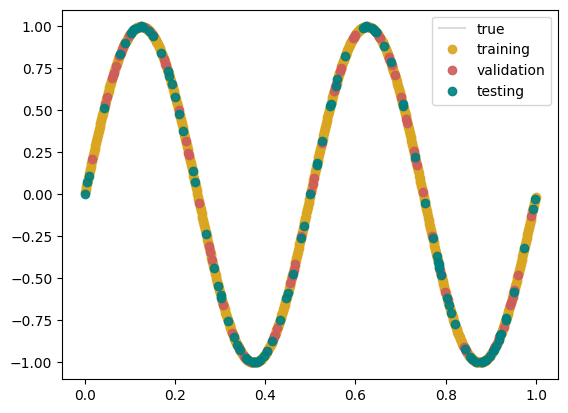

In [ ]:
plt.plot(xtrue,ytrue,'k',linestyle='-',linewidth = 0.2,label='true')
plt.plot(xtrain,ytrain,'goldenrod',marker='o',linewidth = 0,alpha=0.9,label='training')
plt.plot(xval,yval,'indianred',marker='o',linewidth = 0,alpha=0.9,label='validation')
plt.plot(xtest,ytest,'teal',marker='o',linewidth = 0,alpha=0.9,label='testing')
plt.legend()
plt.show()

# TIME TO TRAIN

In [ ]:
################################################################################
# set training parameters
ACT_FUNC      = 'tanh' # activation function: sigmoid, relu, tanh
HIDDEN_LAYERS = [10,100]     # hidden layers
BATCH_SIZE    = 20      # batch size
LR            = 0.001   # learning rate
N_EPOCHS      = 10      # number of epochs

OPTIMIZER = 'adam' # optimizer [adam, SGD]
LOSS_FUNC = 'mae'  # loss function [mae, mse]
################################################################################

### Training Notes:
> `ann = defineNN(...)`: create model architecture to populate \\
> `ann.compile(...)`: compile the model (specify loss function, optimizer, & metrics) \\
> `ann.fit(...)`: train model \\
> `ann.predict(...)`: make predictions with model


In [ ]:
# ------ define NN ------
ann = defineNN(HIDDEN_LAYERS,
               input_shape  = 1,
               output_shape = 1,
               act_fun      = ACT_FUNC,
               )

# ------ Training Hyperparameters ------
if OPTIMIZER == 'adam':
  optimizer = tf.optimizers.Adam(learning_rate = LR)

elif OPTIMIZER == 'SGD':
  optimizer = tf.optimizers.SGD(learning_rate = LR, momentum = 0)

if LOSS_FUNC == 'mae':
  loss_func = tf.keras.losses.MeanAbsoluteError(name='mean_absolute_error')
elif LOSS_FUNC == 'mse':
  loss_func = tf.keras.losses.MeanSquaredError(name='mean_squared_error')

metrics = [tf.keras.losses.MeanAbsoluteError(name='mean_absolute_error'),tf.keras.losses.MeanSquaredError(name='mean_squared_error')]

# ------ Compile Model -----
ann.compile(optimizer = optimizer,
            loss = loss_func,
            metrics = metrics)

# ------ Train -----
start_time = time.time()
history = ann.fit(xtrain,ytrain,
                  validation_data = [xval,yval],
                  batch_size = BATCH_SIZE,
                  epochs = N_EPOCHS,
                  shuffle = True,
                  verbose = 0,
                  )
stop_time = time.time()
tf.print(f"Elapsed time during fit = {(stop_time - start_time):.2f} seconds\n")

Elapsed time during fit = 2.06 seconds



# LETS TAKE A LOOK
To check how well the network performed, we look at the loss values for the training and validation data

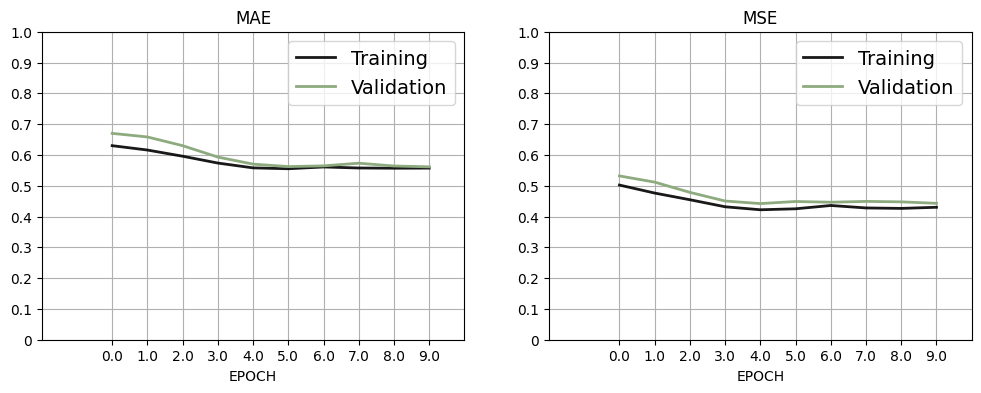

In [ ]:
#---------- plot loss -------------------
trainColor = 'k'
valColor = (141/255,171/255,127/255,1.)
FS = 14
plt.figure(figsize=(12, 4))

ax = plt.subplot(1,2,1)
plt.plot(history.history['mean_absolute_error'], color=trainColor, label='Training',alpha=0.9,linewidth=2)
plt.plot(history.history['val_mean_absolute_error'], color=valColor, label='Validation',alpha=1,linewidth=2)
plt.title('MAE')
plt.xlabel('EPOCH')
plt.legend(frameon=True, fontsize=FS)
plt.xticks(np.arange(0,N_EPOCHS,N_EPOCHS/10),labels=np.arange(0,N_EPOCHS,N_EPOCHS/10))
plt.yticks(np.arange(0,1.1,.1),labels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.ylim(0,1)
plt.grid(True)
plt.xlim(-2, N_EPOCHS)

ax = plt.subplot(1,2,2)
plt.plot(history.history['mean_squared_error'], color=trainColor, label='Training',alpha=0.9,linewidth=2)
plt.plot(history.history['val_mean_squared_error'], color=valColor, label='Validation',alpha=1,linewidth=2)
plt.title('MSE')
plt.xlabel('EPOCH')
plt.legend(frameon=True, fontsize=FS)
plt.xticks(np.arange(0,N_EPOCHS,N_EPOCHS/10),labels=np.arange(0,N_EPOCHS,N_EPOCHS/10))
plt.yticks(np.arange(0,1.1,.1),labels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.ylim(0,1)
plt.grid(True)
plt.xlim(-2, N_EPOCHS)
plt.show()

Let's also plot the network's predictions compared to truth

4/4 [==============================] - 0s 3ms/step


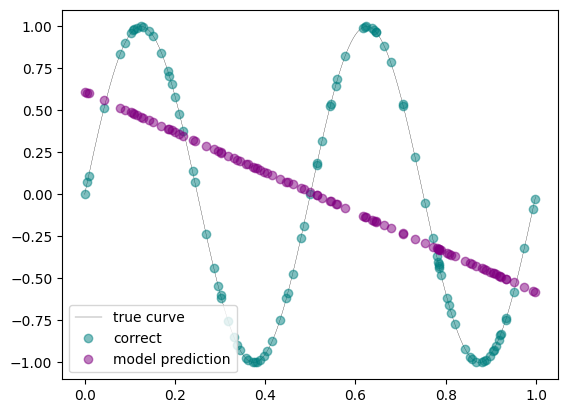

In [ ]:
pred = ann.predict(xtest)
plt.plot(xtrue,ytrue,'k',linestyle='-',linewidth = 0.2,label='true curve')
plt.plot(xtest,ytest,'teal',marker='o',linewidth = 0,alpha=0.5,label='correct')
plt.plot(xtest,pred,'purple',marker='o',linewidth = 0,alpha=0.5,label='model prediction')
plt.legend()
plt.show()

# Do NOT look past here... until I say so
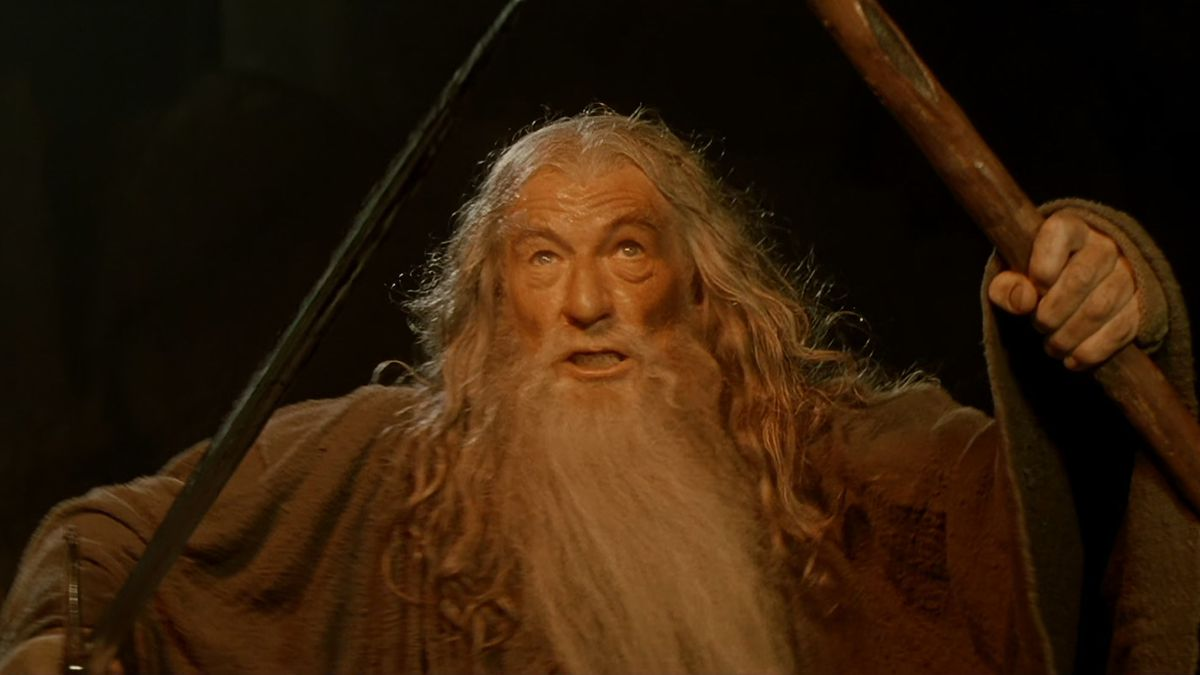

In [ ]:
# set of training parameters that worked well for me
ACT_FUNC      = 'sigmoid' # activation function: sigmoid, relu, tanh
HIDDEN_LAYERS = [10,100]  # hidden layers
BATCH_SIZE    = 36        # batch size
LR            = 0.01      # learning rate
N_EPOCHS      = 1000      # number of epochs ---> then do 50 epochs! lets compare...

OPTIMIZER = 'adam' # optimizer [adam, SGD]
LOSS_FUNC = 'mae'  # loss function [mae, mse]